# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import torch.nn.functional as F

In [2]:
class HandwrittenDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = self.data.iloc[:, 0].values  # Asumsikan kolom pertama adalah label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_array = self.data.iloc[idx, 1:].values.astype(np.uint8)
        img_array = img_array.reshape(28, 28)
        img = Image.fromarray(img_array)
        
        if self.transform:
            img = self.transform(img)
            
        label = self.labels[idx]
        return img, label

In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.deconv3 = nn.Conv2d(256, 128, 3, padding=1)
        self.deconv3_bn = nn.BatchNorm2d(128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.deconv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.deconv2_bn = nn.BatchNorm2d(64)
        
        # Output layer
        self.fc = nn.Linear(64 * 28 * 28, 26)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # Encoding path
        x1 = F.relu(self.conv1_bn(self.conv1(x)))
        x1p = self.pool(x1)
        x2 = F.relu(self.conv2_bn(self.conv2(x1p)))
        x2p = self.pool(x2)
        x3 = F.relu(self.conv3_bn(self.conv3(x2p)))
        
        # Decoding path
        x = self.upconv3(x3)
        x = torch.cat([x, x2], dim=1)
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = self.upconv2(x)
        x = torch.cat([x, x1], dim=1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        
        # Flatten and classify
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((28, 28)),
    transforms.RandomApply([transforms.RandomInvert()], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = HandwrittenDataset('A_Z Handwritten Data.csv', transform=train_transform)

labels = full_dataset.labels

# Definisikan StratifiedShuffleSplit untuk train, val, test
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(split1.split(np.zeros(len(labels)), labels))

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(split2.split(np.zeros(len(labels[temp_idx])), labels[temp_idx]))

# Buat subset
train_subset = Subset(full_dataset, train_idx)
val_subset = Subset(full_dataset, temp_idx[val_idx])
test_subset = Subset(full_dataset, temp_idx[test_idx])

# Terapkan transformasi test dan val
val_subset.dataset.transform = test_transform
test_subset.dataset.transform = test_transform

# Buat DataLoader
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

class_weights = compute_class_weight('balanced', classes=np.unique(full_dataset.labels), y=full_dataset.labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using cuda


In [5]:
num_epochs = 10
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validasi
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%')
    
    # Simpan model terbaik
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Evaluasi pada Test Set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.1379, Val Loss: 0.0615, Val Accuracy: 98.31%
Epoch [2/10], Train Loss: 0.0483, Val Loss: 0.0402, Val Accuracy: 98.87%
Epoch [3/10], Train Loss: 0.0309, Val Loss: 0.0329, Val Accuracy: 99.17%
Epoch [4/10], Train Loss: 0.0212, Val Loss: 0.0247, Val Accuracy: 99.32%
Epoch [5/10], Train Loss: 0.0151, Val Loss: 0.0226, Val Accuracy: 99.44%
Epoch [6/10], Train Loss: 0.0115, Val Loss: 0.0231, Val Accuracy: 99.41%
Epoch [7/10], Train Loss: 0.0093, Val Loss: 0.0233, Val Accuracy: 99.56%
Epoch [8/10], Train Loss: 0.0072, Val Loss: 0.0238, Val Accuracy: 99.48%
Epoch [9/10], Train Loss: 0.0063, Val Loss: 0.0253, Val Accuracy: 99.56%
Epoch [10/10], Train Loss: 0.0052, Val Loss: 0.0301, Val Accuracy: 99.55%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4496\1256747732.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 99.50%


In [6]:
model_save_path = 'cnn_a_z_uNetmodel.pth'
torch.save(model.state_dict(), model_save_path)

---

In [7]:
import os
import re
import math
from collections import defaultdict
import numpy as np
import cv2
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 26)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet()
model.load_state_dict(torch.load('cnn_a_z_uNetmodel.pth'))
model.to(device)
model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4496\3375498121.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_a_z_uNetmodel.pth'))


UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), pad

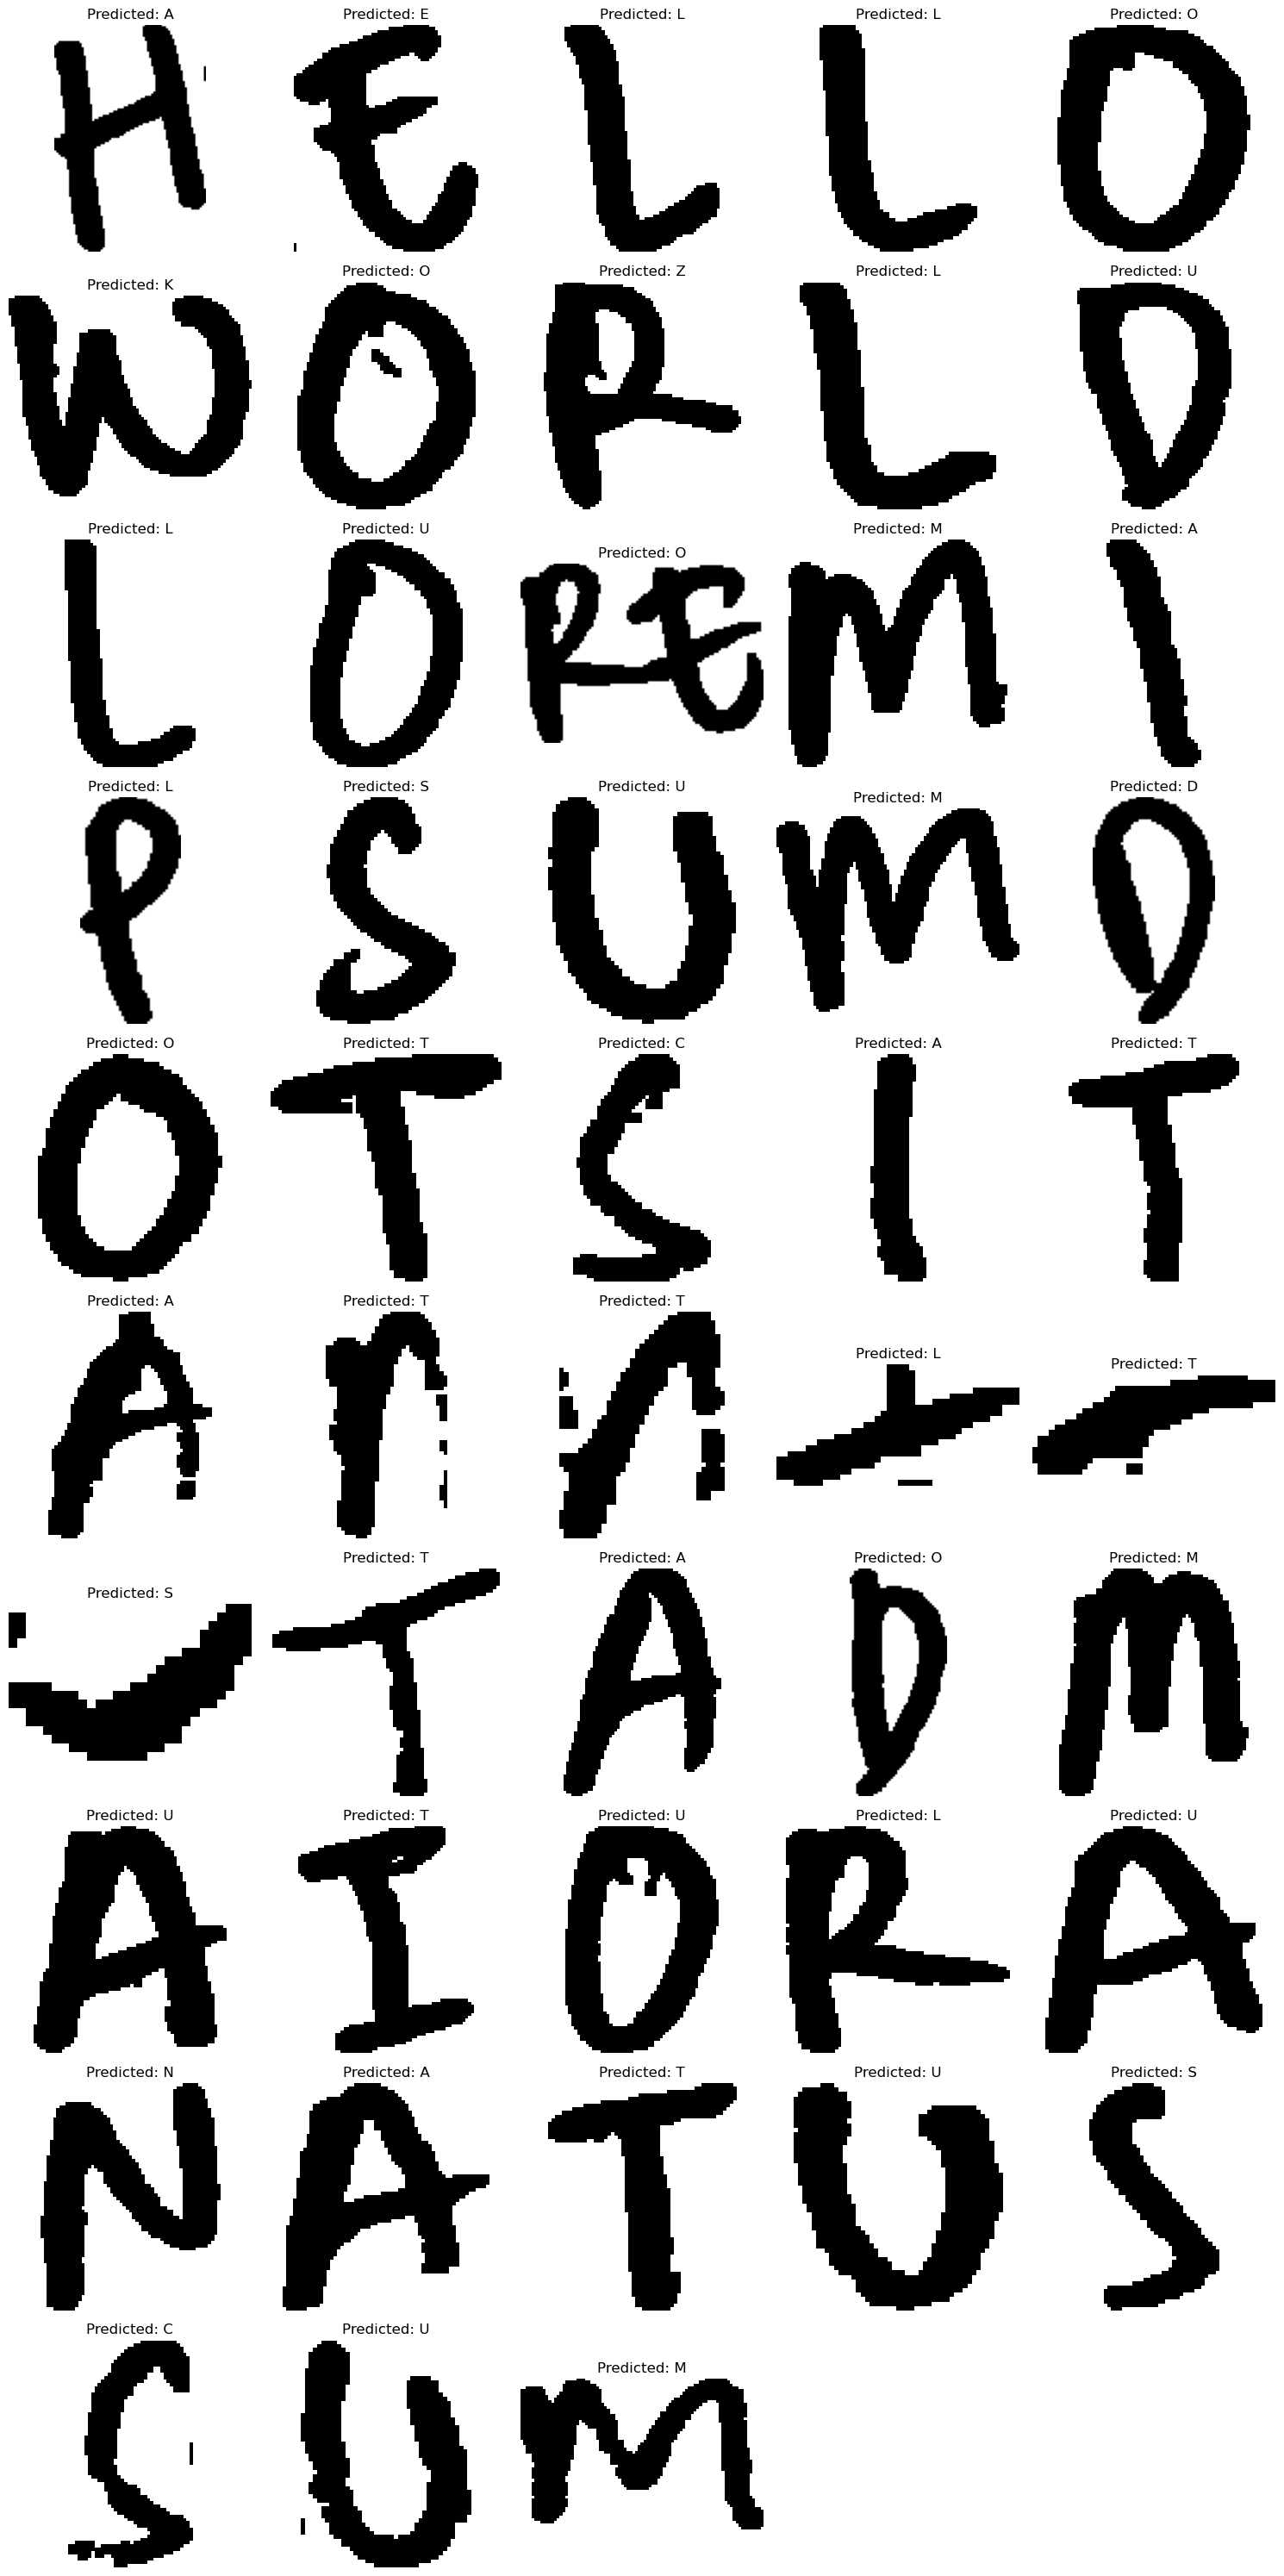

AELLO KOZLU
LUOM ALSUM DOT CAT ATTLTST
AO MUTULU NATUS CUM



In [14]:
class PadToSquareTransform:
    def __init__(self, fill=0):
        self.fill = fill
    def __call__(self, img):
        return pad_to_square(img, fill=self.fill)

def pad_to_square(img, padding_mode='constant', fill='white'):
    """
    Menambahkan padding ke gambar sehingga menjadi persegi dengan warna padding putih.

    Args:
        img (PIL.Image.Image): Gambar yang akan diproses.
        padding_mode (str, optional): Mode padding. Default adalah 'constant'.
        fill (str atau tuple, optional): Warna yang digunakan untuk padding. Default adalah 'white'.

    Returns:
        PIL.Image.Image: Gambar yang telah dipadding menjadi persegi.
    """
    width, height = img.size
    # Tentukan sisi terbesar
    max_side = max(width, height)
    
    # Hitung padding untuk masing-masing sisi
    padding_left = (max_side - width) // 2
    padding_right = max_side - width - padding_left
    padding_top = (max_side - height) // 2
    padding_bottom = max_side - height - padding_top

    # Tambahkan padding sehingga gambar menjadi persegi dengan warna putih
    img_padded = ImageOps.expand(
        img, 
        border=(padding_left, padding_top, padding_right, padding_bottom), 
        fill=fill
    )
    return img_padded

def predict_image(model, image_path):
    image = Image.open(image_path).convert('L')
    image = ImageOps.invert(image)
    img_array = np.array(image)
    kernel = np.ones((2, 2), np.uint8)
    img_array = cv2.dilate(img_array, kernel, iterations=1)
    image = Image.fromarray(img_array)

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return chr(65 + predicted.item())

def predict_folder(model, folder_path):
    results = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        prediction = predict_image(model, image_path)
        results.append((filename, prediction))
    return results

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'([0-9]+)', s)]

def display_sorted_predictions(predictions):
    # Urutkan prediksi berdasarkan nama file secara numerik
    sorted_predictions = sorted(predictions, key=lambda x: natural_sort_key(x[0]))
    
    # Grup prediksi berdasarkan nomor baris dan kata
    lines = defaultdict(lambda: defaultdict(list))
    
    for filename, pred in sorted_predictions:
        # Ekstrak indeks baris, kata, dan karakter dari nama file
        match = re.match(r'char_(\d+)_(\d+)_(\d+)\.png', filename)
        if match:
            line_idx = int(match.group(1))
            word_idx = int(match.group(2))
            char_idx = int(match.group(3))
            lines[line_idx][word_idx].append((char_idx, filename, pred))
    
    # Hitung dimensi grid untuk plotting
    n_images = len(sorted_predictions)
    n_cols = 5
    n_rows = math.ceil(n_images / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    idx = 0
    for line_idx in sorted(lines.keys()):
        for word_idx in sorted(lines[line_idx].keys()):
            chars = sorted(lines[line_idx][word_idx], key=lambda x: x[0])
            for char_idx, filename, pred in chars:
                img = Image.open(os.path.join("chars", filename))
                axes[idx].imshow(img, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Predicted: {pred}')
                idx += 1
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Cetak teks prediksi dengan spasi antar kata
    result = ''
    for line_idx in sorted(lines.keys()):
        for word_idx in sorted(lines[line_idx].keys()):
            chars = sorted(lines[line_idx][word_idx], key=lambda x: x[0])
            word_text = ''.join(pred for _, _, pred in chars)
            result += word_text + ' '  # Tambahkan spasi antar kata
        result = result.strip() + '\n'  # Hapus spasi di akhir baris dan tambahkan newline
    print(result)
    
    return result

predictions = predict_folder(model, "chars")
result = display_sorted_predictions(predictions)

* Class weight/undersampling
* Penambahan padding
* Pemisahan karakter yang dempet
* Perbandingan dengan resnet